In [4]:
# Mount google drive to our notebook

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#**Library**

In [6]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.0

     |████████████████████████████████| 440kB 2.8MB/s 
     |████████████████████████████████| 235kB 12.6MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 


In [7]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [9]:
# -*- coding: utf-8 -*-
#
# Copyright 2018-2020 Data61, CSIRO
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Dropout, LSTM, Dense, Permute, Reshape
from stellargraph.mapper import SlidingFeaturesNodeGenerator
from stellargraph.core.experimental import experimental
from stellargraph.core.utils import calculate_laplacian


class FixedAdjacencyGraphConvolution(Layer):

    """
    Graph Convolution (GCN) Keras layer.
    The implementation is based on https://github.com/tkipf/keras-gcn.

    Original paper: Semi-Supervised Classification with Graph Convolutional Networks. Thomas N. Kipf, Max Welling,
    International Conference on Learning Representations (ICLR), 2017 https://github.com/tkipf/gcn

    Notes:
      - The inputs are 3 dimensional tensors: batch size, sequence length, and number of nodes.
      - This class assumes that a simple unweighted or weighted adjacency matrix is passed to it,
        the normalized Laplacian matrix is calculated within the class.

    Args:
        units (int): dimensionality of output feature vectors
        A (N x N): weighted/unweighted adjacency matrix
        activation (str or func): nonlinear activation applied to layer's output to obtain output features
        use_bias (bool): toggles an optional bias
        kernel_initializer (str or func, optional): The initialiser to use for the weights.
        kernel_regularizer (str or func, optional): The regulariser to use for the weights.
        kernel_constraint (str or func, optional): The constraint to use for the weights.
        bias_initializer (str or func, optional): The initialiser to use for the bias.
        bias_regularizer (str or func, optional): The regulariser to use for the bias.
        bias_constraint (str or func, optional): The constraint to use for the bias.
    """

    def __init__(
        self,
        units,
        A,
        activation=None,
        use_bias=True,
        input_dim=None,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer="zeros",
        bias_regularizer=None,
        bias_constraint=None,
        **kwargs,
    ):
        if "input_shape" not in kwargs and input_dim is not None:
            kwargs["input_shape"] = (input_dim,)

        self.units = units
        self.adj = calculate_laplacian(A)
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        super().__init__(**kwargs)

    def get_config(self):
        """
        Gets class configuration for Keras serialization.
        Used by Keras model serialization.

        Returns:
            A dictionary that contains the config of the layer
        """

        config = {
            "units": self.units,
            "use_bias": self.use_bias,
            "activation": activations.serialize(self.activation),
            "kernel_initializer": initializers.serialize(self.kernel_initializer),
            "kernel_regularizer": regularizers.serialize(self.kernel_regularizer),
            "kernel_constraint": constraints.serialize(self.kernel_constraint),
            "bias_initializer": initializers.serialize(self.bias_initializer),
            "bias_regularizer": regularizers.serialize(self.bias_regularizer),
            "bias_constraint": constraints.serialize(self.bias_constraint),
        }

        base_config = super().get_config()
        return {**base_config, **config}


    def compute_output_shape(self, input_shapes):
        """
        Computes the output shape of the layer.
        Assumes the following inputs:

        Args:
            input_shapes (tuple of int)
                Shape tuples can include None for free dimensions, instead of an integer.

        Returns:
            An input shape tuple.
        """
        feature_shape = input_shapes

        return feature_shape[0], feature_shape[1], self.units


    def build(self, input_shapes):
        """
        Builds the layer

        Args:
            input_shapes (list of int): shapes of the layer's inputs (the batches of node features)

        """
        _batch_dim, n_nodes, features = input_shapes

        self.A = self.add_weight(
            name="A",
            shape=(n_nodes, n_nodes),
            trainable=False,
            initializer=initializers.constant(self.adj),
        )
        self.kernel = self.add_weight(
            shape=(features, self.units),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                # ensure the per-node bias can be broadcast across each feature
                shape=(n_nodes, 1),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
            )
        else:
            self.bias = None
        self.built = True


    def call(self, features):
        """
        Applies the layer.

        Args:
            features (ndarray): node features (size B x N x F), where B is the batch size, F = TV is
                the feature size (consisting of the sequence length and the number of variates), and
                N is the number of nodes in the graph.

        Returns:
            Keras Tensor that represents the output of the layer.
        """

        # Calculate the layer operation of GCN
        # shape = B x F x N
        nodes_last = tf.transpose(features, [0, 2, 1])
        neighbours = K.dot(nodes_last, self.A)

        # shape = B x N x F
        h_graph = tf.transpose(neighbours, [0, 2, 1])
        # shape = B x N x units
        output = K.dot(h_graph, self.kernel)

        # Add optional bias & apply activation
        if self.bias is not None:
            output += self.bias

        output = self.activation(output)

        return output



@experimental(
    reason="Lack of unit tests and code refinement", issues=[1132, 1526, 1564]
)
class GCN_LSTM:

    """
    GCN_LSTM is a univariate timeseries forecasting method. The architecture  comprises of a stack of N1 Graph Convolutional layers followed by N2 LSTM layers, a Dropout layer, and  a Dense layer.
    This main components of GNN architecture is inspired by: T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction (https://arxiv.org/abs/1811.05320).
    The implementation of the above paper is based on one graph convolution layer stacked with a GRU layer.

    The StellarGraph implementation is built as a stack of the following set of layers:

    1. User specified no. of Graph Convolutional layers
    2. User specified no. of LSTM layers
    3. 1 Dense layer
    4. 1 Dropout layer.

    The last two layers consistently showed better performance and regularization experimentally.

    .. seealso::

       Example using GCN_LSTM: `spatio-temporal time-series prediction <https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html>`__.

       Appropriate data generator: :class:`.SlidingFeaturesNodeGenerator`.

       Related model: :class:`.GCN` for graphs without time-series node features.

    Args:
       seq_len: No. of LSTM cells
       adj: unweighted/weighted adjacency matrix of [no.of nodes by no. of nodes dimension
       gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.
       lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.
       generator (SlidingFeaturesNodeGenerator): A generator instance.
       bias (bool): If True, a bias vector is learnt for each layer in the GCN model.
       dropout (float): Dropout rate applied to input features of each GCN layer.
       gc_activations (list of str or func): Activations applied to each layer's output; defaults to ``['relu', ..., 'relu']``.
       lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.
       kernel_initializer (str or func, optional): The initialiser to use for the weights of each layer.
       kernel_regularizer (str or func, optional): The regulariser to use for the weights of each layer.
       kernel_constraint (str or func, optional): The constraint to use for the weights of each layer.
       bias_initializer (str or func, optional): The initialiser to use for the bias of each layer.
       bias_regularizer (str or func, optional): The regulariser to use for the bias of each layer.
       bias_constraint (str or func, optional): The constraint to use for the bias of each layer.
     """

    def __init__(
        self,
        seq_len,
        adj,
        gc_layer_sizes,
        lstm_layer_sizes,
        gc_activations=None,
        generator=None,
        lstm_activations=None,
        bias=True,
        dropout=0.5,
        kernel_initializer=None,
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer=None,
        bias_regularizer=None,
        bias_constraint=None,
    ):
        if generator is not None:
            if not isinstance(generator, SlidingFeaturesNodeGenerator):
                raise ValueError(
                    f"generator: expected a SlidingFeaturesNodeGenerator, found {type(generator).__name__}"
                )

            if seq_len is not None or adj is not None:
                raise ValueError(
                    "expected only one of generator and (seq_len, adj) to be specified, found multiple"
                )

            adj = generator.graph.to_adjacency_matrix(weighted=True).todense()
            seq_len = generator.window_size
            variates = generator.variates
        else:
            variates = None

        super(GCN_LSTM, self).__init__()

        n_gc_layers = len(gc_layer_sizes)
        n_lstm_layers = len(lstm_layer_sizes)

        self.lstm_layer_sizes = lstm_layer_sizes
        self.gc_layer_sizes = gc_layer_sizes
        self.bias = bias
        self.dropout = dropout
        self.adj = adj
        self.n_nodes = adj.shape[0]
        self.n_features = seq_len
        self.seq_len = seq_len
        self.multivariate_input = variates is not None
        self.variates = variates if self.multivariate_input else 1
        self.outputs = self.n_nodes * self.variates

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        # Activation function for each gcn layer
        if gc_activations is None:
            gc_activations = ["relu"] * n_gc_layers
        elif len(gc_activations) != n_gc_layers:
            raise ValueError(
                "Invalid number of activations; require one function per graph convolution layer"
            )
        self.gc_activations = gc_activations

        # Activation function for each lstm layer
        if lstm_activations is None:
            lstm_activations = ["tanh"] * n_lstm_layers
        elif len(lstm_activations) != n_lstm_layers:
            padding_size = n_lstm_layers - len(lstm_activations)
            if padding_size > 0:
                lstm_activations = lstm_activations + ["tanh"] * padding_size
            else:
                raise ValueError(
                    "Invalid number of activations; require one function per lstm layer"
                )
        self.lstm_activations = lstm_activations

        self._gc_layers = [
            FixedAdjacencyGraphConvolution(
                units=self.variates * layer_size,
                A=self.adj,
                activation=activation,
                kernel_initializer=self.kernel_initializer,
                kernel_regularizer=self.kernel_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_initializer=self.bias_initializer,
                bias_regularizer=self.bias_regularizer,
                bias_constraint=self.bias_constraint,
            )
            for layer_size, activation in zip(self.gc_layer_sizes, self.gc_activations)
        ]
        self._lstm_layers = [
            LSTM(layer_size, activation=activation, return_sequences=True)
            for layer_size, activation in zip(
                self.lstm_layer_sizes[:-1], self.lstm_activations
            )
        ]
        self._lstm_layers.append(
            LSTM(
                self.lstm_layer_sizes[-1],
                activation=self.lstm_activations[-1],
                return_sequences=False,
            )
        )
        self._decoder_layer = Dense(self.outputs, activation="relu")

    def __call__(self, x):

        x_in, out_indices = x

        h_layer = x_in
        if not self.multivariate_input:
            # normalize to always have a final variate dimension, with V = 1 if it doesn't exist
            # shape = B x N x T x 1
            h_layer = tf.expand_dims(h_layer, axis=-1)

        # flatten variates into sequences, for convolution
        # shape B x N x (TV)
        h_layer = Reshape((self.n_nodes, self.seq_len * self.variates))(h_layer)

        for layer in self._gc_layers:
            h_layer = layer(h_layer)

        # return the layer to its natural multivariate tensor form
        # shape B x N x T' x V (where T' is the sequence length of the last GC)
        h_layer = Reshape((self.n_nodes, -1, self.variates))(h_layer)
        # put time dimension first for LSTM layers
        # shape B x T' x N x V
        h_layer = Permute((2, 1, 3))(h_layer)
        # flatten the variates across all nodes, shape B x T' x (N V)
        h_layer = Reshape((-1, self.n_nodes * self.variates))(h_layer)

        for layer in self._lstm_layers:
            h_layer = layer(h_layer)

        h_layer = Dropout(self.dropout)(h_layer)
        h_layer = self._decoder_layer(h_layer)

        if self.multivariate_input:
            # flatten things out to the multivariate shape
            # shape B x N x V
            h_layer = Reshape((self.n_nodes, self.variates))(h_layer)

        return h_layer

    def in_out_tensors(self):
        """
        Builds a GCN model for node  feature prediction

        Returns:
            tuple: ``(x_inp, x_out)``, where ``x_inp`` is a list of Keras/TensorFlow
                input tensors for the GCN model and ``x_out`` is a tensor of the GCN model output.
        """
        # Inputs for features
        if self.multivariate_input:
            shape = (None, self.n_nodes, self.n_features, self.variates)
        else:
            shape = (None, self.n_nodes, self.n_features)

        x_t = Input(batch_shape=shape)

        # Indices to gather for model output
        out_indices_t = Input(batch_shape=(None, self.n_nodes), dtype="int32")

        x_inp = [x_t, out_indices_t]
        x_out = self(x_inp)

        return x_inp[0], x_out

In [10]:
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# **Data Preprocessing**

## Load Data From CSV

In [11]:
fdir = '/content/gdrive/My Drive/Projects/COVID-19/LSTM-GCN_COVID-19/datasets/same_length_main_data.csv'
data = pd.read_csv(fdir)

In [12]:
data

,Unnamed: 0,Unnamed: 0.1,province,date,confirmed,confirmed (cumulative),deaths,deaths (cumulative),recovered,recovered (cumulative),population,area ($km^2$),north border (latitude),south border (latitude),east border (longitude),west border (longitude),capital,capital coordinate (latitude),capital coordinate (longitude)
0,0,0,ACEH,01-03-2020,0.0,0.0,0.0,0.0,0.0,0.0,5.316.300,57.956,6.274450,1.458694,98.686188,94.771712,Banda Aceh,5.552846,95.319291
1,1,1,ACEH,02-03-2020,0.0,0.0,0.0,0.0,0.0,0.0,5.316.300,57.956,6.274450,1.458694,98.686188,94.771712,Banda Aceh,5.552846,95.319291
2,2,2,ACEH,03-03-2020,0.0,0.0,0.0,0.0,0.0,0.0,5.316.300,57.956,6.274450,1.458694,98.686188,94.771712,Banda Aceh,5.552846,95.319291
3,3,3,ACEH,04-03-2020,0.0,0.0,0.0,0.0,0.0,0.0,5.316.300,57.956,6.274450,1.458694,98.686188,94.771712,Banda Aceh,5.552846,95.319291
4,4,4,ACEH,05-03-2020,0.0,0.0,0.0,0.0,0.0,0.0,5.316.300,57.956,6.274450,1.458694,98.686188,94.771712,Banda Aceh,5.552846,95.319291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,4143,117,SUMATERA_UTARA,26-06-2020,14.0,1361.0,4.0,86.0,64.0,356.0,14.639.400,72.981,4.439239,-1.033638,100.660301,96.720388,Medan,3.589665,98.673826
4144,4144,118,SUMATERA_UTARA,27-06-2020,75.0,1436.0,5.0,91.0,18.0,374.0,14.639.400,72.981,4.439239,-1.033638,100.660301,96.720388,Medan,3.589665,98.673826
4145,4145,119,SUMATERA_UTARA,28-06-2020,22.0,1458.0,0.0,91.0,10.0,384.0,14.639.400,72.981,4.439239,-1.033638,100.660301,96.720388,Medan,3.589665,98.673826
4146,4146,120,SUMATERA_UTARA,29-06-2020,12.0,1470.0,0.0,91.0,17.0,401.0,14.639.400,72.981,4.439239,-1.033638,100.660301,96.720388,Medan,3.589665,98.673826


In [13]:
fdir = '/content/gdrive/My Drive/Projects/COVID-19/LSTM-GCN_COVID-19/datasets/prov_details_dataframe.csv'
prov_details = pd.read_csv(fdir)

In [14]:
prov_details

,Unnamed: 0,province,population,area ($km^2$),north border (latitude),south border (latitude),east border (longitude),west border (longitude),capital,capital coordinate (latitude),capital coordinate (longitude)
0,0,ACEH,5.316.300,57.956,6.274450,1.458694,98.686188,94.771712,Banda Aceh,5.552846,95.319291
1,1,BALI,4.362.000,5.780,-8.061589,-8.850432,115.711499,114.431533,Denpasar,-8.652497,115.219118
2,2,BANTEN,12.959.200,9.663,-5.499638,-7.456589,106.780013,104.651318,Serang,-6.105650,105.987733
3,3,BENGKULU,1.971.800,19.919,-2.277136,-5.718987,103.781067,100.330919,Bengkulu,-3.518676,102.535983
4,4,DAERAH_ISTIMEWA_YOGYAKARTA,3.868.600,3.133,-7.541289,-8.415904,110.838690,109.901789,Yogyakarta,-7.801195,110.364917
5,5,DKI_JAKARTA,10.504.100,664.000,-4.999364,-6.374458,106.973975,106.314673,Jakarta,-6.175394,106.827183
6,6,GORONTALO,1.176.400,11.257,1.364714,-0.066563,123.551923,121.155997,Gorontalo,0.718617,122.455593
7,7,JAMBI,3.566.200,50.058,-0.508882,-2.782260,105.012209,101.122559,Jambi,-1.611572,102.779699
8,8,JAWA_BARAT,49.023.200,35.378,-4.038794,-8.020748,109.069791,106.050951,Bandung,-6.934469,107.604954
9,9,JAWA_TENGAH,34.552.500,32.801,-4.038794,-8.441188,111.868970,108.555855,Semarang,-6.990399,110.422910


In [15]:
# csv -> pandas -> P x T numpy array, P = number of province, T = number of days

cml_new_case = np.zeros((34, int(len(data)/34)))

for i in range (34):
  cml_new_case[i,:] = np.array(data['confirmed (cumulative)'][i*int(len(data)/34):(i+1)*int(len(data)/34)])

In [16]:
# normalized to total number of local population

cml_new_case_norm = cml_new_case.copy()

for i in range (34):
  cml_new_case_norm[i,:] = 100000*cml_new_case_norm[i,:]/int(prov_details['population'][i].replace('.', ''))

In [ ]:
miu = np.average(cml_new_case)
sigma = np.std(cml_new_case)

sigma/miu

2.7522523932197047

In [12]:
def minmax_scale(m, i):
  a = m[i, :].copy()
  return (a - m.min())/(m.max() - m.min())

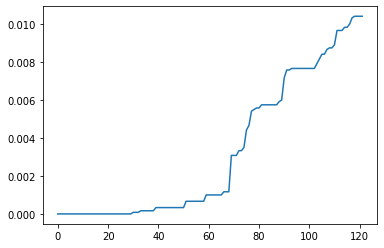

In [13]:
plt.plot(minmax_scale(cml_new_case, 3))

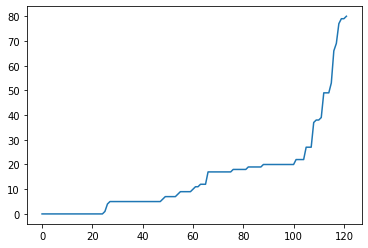

In [14]:
plt.plot(cml_new_case[0,:])

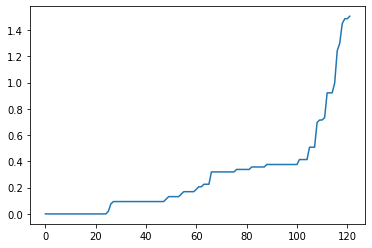

In [15]:
plt.plot(cml_new_case_norm[0,:])

In [17]:
cml_new_case = pd.DataFrame(cml_new_case)
cml_new_case_norm = pd.DataFrame(cml_new_case_norm)

cml_new_case_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018810,0.075240,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,0.094050,...,0.357391,0.357391,0.357391,0.357391,0.357391,0.357391,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.376201,0.413822,0.413822,0.413822,0.413822,0.507872,0.507872,0.507872,0.695973,0.714783,0.714783,0.733593,0.921694,0.921694,0.921694,0.996934,1.241465,1.297895,1.448376,1.485996,1.485996,1.504806
1,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022925,0.229253,0.229253,0.366804,0.366804,0.435580,0.550206,0.618982,0.779459,0.779459,0.917011,1.237964,...,8.505273,8.688675,8.826227,8.872077,9.124255,9.307657,9.422283,9.949564,10.224668,10.453920,10.843650,10.958276,11.027052,11.485557,11.806511,12.563044,13.136176,13.411279,13.732233,14.465841,14.901421,15.726731,16.368638,16.781293,17.216873,17.721229,18.798716,20.288858,22.145805,22.948189,23.773498,24.484182,25.286566,26.295277,27.579092,28.702430,31.155433,32.187070,32.851903,33.975241
2,0.00000,0.00000,0.000000,0.000000,0.000000,0.007717,0.007717,0.015433,0.015433,0.015433,0.015433,0.015433,0.023150,0.030866,0.038583,0.046299,0.046299,0.046299,0.046299,0.046299,0.046299,0.046299,0.046299,0.046299,0.046299,0.046299,0.239212,0.316378,0.331811,0.501574,0.609606,0.702204,0.748503,0.779369,0.802519,0.833385,0.902834,0.949133,1.095747,1.118896,...,5.463300,5.463300,5.625347,5.625347,5.764245,5.841410,5.949441,6.049756,6.157788,6.180937,6.234953,6.342984,6.890857,6.968023,7.153219,7.431014,7.508180,7.593061,7.716526,7.978888,8.171801,8.441879,9.012902,9.082351,9.113217,9.398728,9.637941,9.769122,9.807704,9.931169,10.000617,10.062350,10.139515,10.293845,10.417310,10.509908,10.664239,10.687388,10.702821,10.772270
3,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050715,0.050715,0.050715,0.101430,0.101430,0.101430,0.101430,0.101430,0.101430,0.202860,...,3.499341,3.499341,3.499341,3.499341,3.499341,3.499341,3.600771,3.651486,4.361497,4.615073,4.615073,4.665788,4.665788,4.665788,4.665788,4.665788,4.665788,4.665788,4.665788,4.665788,4.665788,4.817933,4.970078,5.122223,5.122223,5.274369,5.325084,5.325084,5.426514,5.882950,5.882950,5.882950,5.984380,5.984380,6.085810,6.288670,6.339385,6.339385,6.339385,6.339385
4,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025849,0.025849,0.025849,0.025849,0.025849,0.025849,0.025849,0.025849,0.025849,0.025849,0.025849,0.051698,0.051698,0.051698,0.077547,0.206793,0.336039,0.336039,0.336039,0.465285,0.491134,0.568681,0.594530,0.594530,0.646229,...,5.299075,5.428320,5.454169,5.454169,5.454169,5.505868,5.505868,5.557566,5.635113,5.712661,5.738510,5.738510,5.738510,5.738510,5.764359,5.867756,5.919454,5.997001,6.048700,6.074549,6.126247,6.384739,6.436437,6.565683,6.643230,6.669079,6.746627,6.746627,6.772476,6.979269,7.056816,7.056816,7.134364,7.160213,7.341157,7.418704,7.470403,7.522101,7.522101,7.703045
5,0.02856,0.04760,0.066641,0.085681,0.085681,0.085681,0.085681,0.085681,0.085681,

In [18]:
fdir = '/content/gdrive/My Drive/Projects/COVID-19/LSTM-GCN_COVID-19/datasets/adjacency_matrix.csv'
prov_adj = np.genfromtxt(fdir, delimiter = ',')

In [19]:
prov_adj

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

## Split Train-Test Data

In [20]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [38]:
train_rate = 1

In [39]:
train_data, test_data = train_test_split(cml_new_case_norm, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (34, 122)
Test data:  (34, 0)


In [40]:
train_data

array([[ 0.        ,  0.        ,  0.        , ...,  1.4859959 ,
         1.4859959 ,  1.50480597],
       [ 0.        ,  0.        ,  0.        , ..., 32.18707015,
        32.8519028 , 33.97524072],
       [ 0.        ,  0.        ,  0.        , ..., 10.68738811,
        10.70282116, 10.77226989],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 13.23113423,
        13.23113423, 13.24938407],
       [ 0.        ,  0.        ,  0.        , ..., 23.51362802,
        23.78430542, 24.10205715],
       [ 0.        ,  0.        ,  0.        , ...,  9.95942457,
        10.04139514, 10.53321857]])

In [41]:
test_data

array([], shape=(34, 0), dtype=float64)

## Data Scaling/Normalizing

In [ ]:
# normalisasi data

train_scaled = 500000*train_data/total_population
test_scaled = 500000*test_data/total_population
print(train_scaled.min(), train_scaled.max())
print(test_scaled.min(), test_scaled.max())

0.0 0.9264385496774729
0.0 0.7419040418148868


In [42]:
# tanpa normalisasi

train_scaled = train_data
test_scaled = test_data

In [ ]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [ ]:
# min-max scaling

train_scaled, test_scaled = scale_data(train_data, test_data)

In [43]:
train_scaled

array([[ 0.        ,  0.        ,  0.        , ...,  1.4859959 ,
         1.4859959 ,  1.50480597],
       [ 0.        ,  0.        ,  0.        , ..., 32.18707015,
        32.8519028 , 33.97524072],
       [ 0.        ,  0.        ,  0.        , ..., 10.68738811,
        10.70282116, 10.77226989],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 13.23113423,
        13.23113423, 13.24938407],
       [ 0.        ,  0.        ,  0.        , ..., 23.51362802,
        23.78430542, 24.10205715],
       [ 0.        ,  0.        ,  0.        , ...,  9.95942457,
        10.04139514, 10.53321857]])

## Sequence Data Preparation for LSTM

In [44]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [81]:
seq_len = 10
pre_len = 5

In [82]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(108, 34, 10)
(108, 34)
(0,)
(0,)


# StellarGraph Graph Convolution and LSTM model

In [57]:
# comment this part if you want to use custom GCN_LSTM class

#from stellargraph.layer import GCN_LSTM

In [102]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=prov_adj,
    gc_layer_sizes=[32, 32, 16],
    gc_activations=["relu", "relu", "relu"],
    lstm_layer_sizes=[200, 200, 200],
    lstm_activations=["sigmoid", "sigmoid", "sigmoid"],
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


In [103]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [104]:
model = Model(inputs=x_input, outputs=x_output)
#model_new = Sequential()
#model_new.add(model)
#model_new.add(Dense(34, activation='relu'))

In [105]:
model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])

In [106]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 34, 10)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims_6 (Te [(None, 34, 10, 1)]       0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 34, 10)            0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 34, 32)            1510      
_________________________________________________________________
fixed_adjacency_graph_convol (None, 34, 32)            2214      
_________________________________________________________________
fixed_adjacency_graph_convol (None, 34, 16)            1702      
_________________________________________________________________
reshape_19 (Reshape)         (None, 34, None, 1)       0   

In [107]:
history = model.fit(
    trainX,
    trainY,
    epochs=1000,
    batch_size=20,
    shuffle=True,
    verbose=1,
    #validation_data=[testX, testY],
)

Epoch 1/1000
6/6 [==============================] - 0s 80ms/step - loss: 6.8359 - accuracy: 0.0463
Epoch 2/1000
6/6 [==============================] - 0s 81ms/step - loss: 6.4935 - accuracy: 0.1667
Epoch 3/1000
6/6 [==============================] - 0s 83ms/step - loss: 6.3744 - accuracy: 0.1019
Epoch 4/1000
6/6 [==============================] - 0s 82ms/step - loss: 6.2277 - accuracy: 0.2037
Epoch 5/1000
6/6 [==============================] - 0s 81ms/step - loss: 6.1520 - accuracy: 0.2870
Epoch 6/1000
6/6 [==============================] - 0s 81ms/step - loss: 5.9803 - accuracy: 0.3611
Epoch 7/1000
6/6 [==============================] - 0s 81ms/step - loss: 5.7738 - accuracy: 0.4722
Epoch 8/1000
6/6 [==============================] - 0s 83ms/step - loss: 5.5212 - accuracy: 0.5185
Epoch 9/1000
6/6 [==============================] - 0s 81ms/step - loss: 5.2631 - accuracy: 0.6111
Epoch 10/1000
6/6 [==============================] - 1s 85ms/step - loss: 4.9032 - accuracy: 0.6389
Epoch 11/

In [ ]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

KeyError: ignored

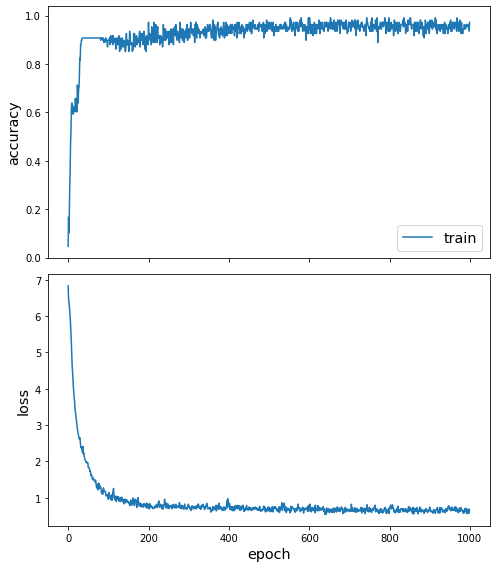

In [108]:
sg.utils.plot_history(history)

In [114]:
# save model

fdir = '/content/gdrive/My Drive/Projects/COVID-19/LSTM-GCN_COVID-19/model/model_2'
model.save(fdir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Projects/COVID-19/LSTM-GCN_COVID-19/model/model_2/assets


In [ ]:
# load model

fdir = '/content/gdrive/My Drive/Projects/COVID-19/LSTM-GCN_COVID-19/model/model_1'
loaded_model = tf.keras.models.load_model(fdir)

In [109]:
ythat = model.predict(trainX)
#yhat = model.predict(testX)

In [110]:
ythat

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 1.4233971, 30.172613 , 10.401044 , ..., 13.159984 , 22.922125 ,
         9.426367 ],
       [ 1.4437288, 30.520164 , 10.456455 , ..., 13.215657 , 23.098925 ,
         9.524128 ],
       [ 1.4542269, 30.720259 , 10.497126 , ..., 13.262556 , 23.213486 ,
         9.580747 ]], dtype=float32)

Text(0.5, 1.0, 'prediction')

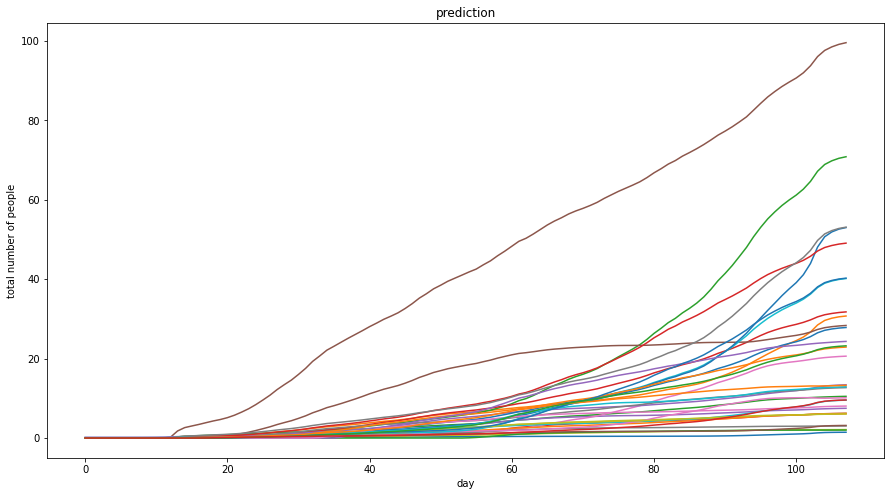

In [111]:
plt.figure(figsize=(15, 8))
plt.plot(ythat)
plt.xlabel("day")
plt.ylabel("total number of people")
plt.title("prediction")

Text(0.5, 1.0, 'true')

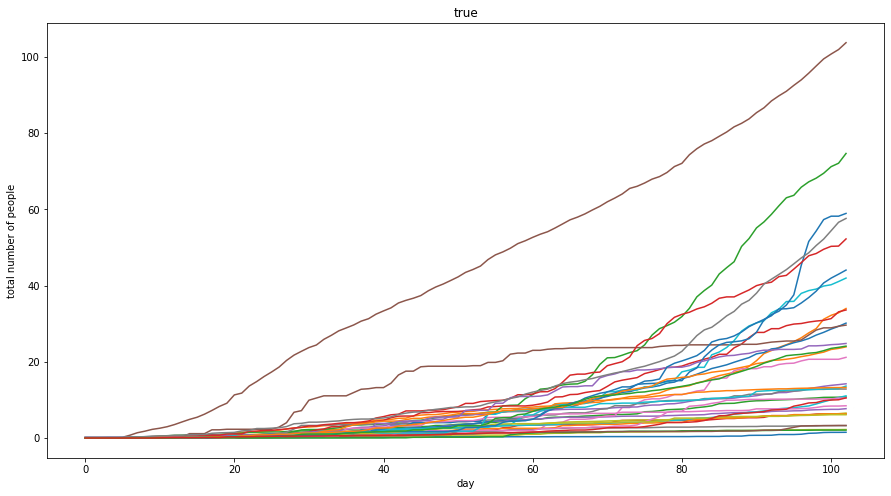

In [68]:
plt.figure(figsize=(15, 8))
plt.plot(trainY)
plt.xlabel("day")
plt.ylabel("total number of people")
plt.title("true")

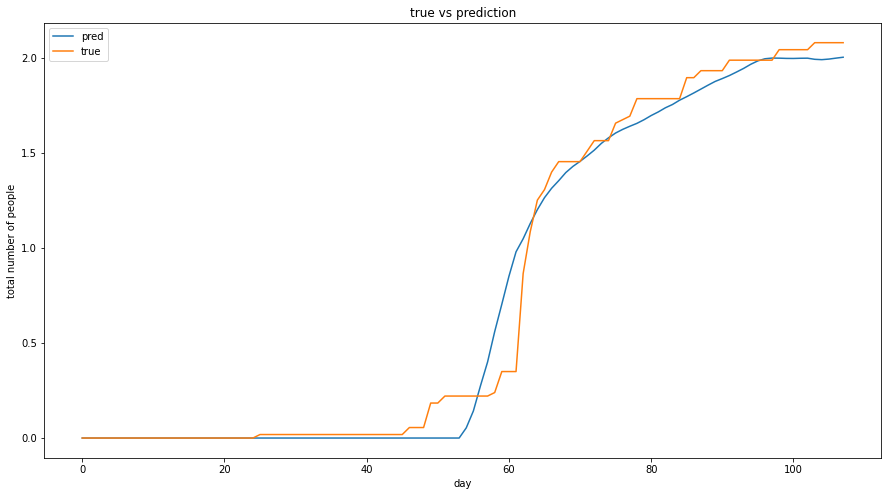

In [162]:
# catatan model_1
# 0, 22, 25 paling parah
# 18 (emang bodoh) mayan jelek
# 15 unik, dia bisa ngikutin lonjakan dan landaian nya

# catatan model_2
# improvement: 0 udah bagus, 15 even better, 18 udah bagus, 22 udah bagus!, 25 udah bagus!
# model sekarang mampu smoothing lonjakan tajam dengan akurat (misal 0, 15, 18, 26, 29)

province = 22

plt.figure(figsize=(15, 8))
plt.plot(ythat[:,province], label='pred')
plt.plot(trainY[:,province], label='true')
plt.xlabel("day")
plt.ylabel("total number of people")
plt.title("true vs prediction")
plt.legend()

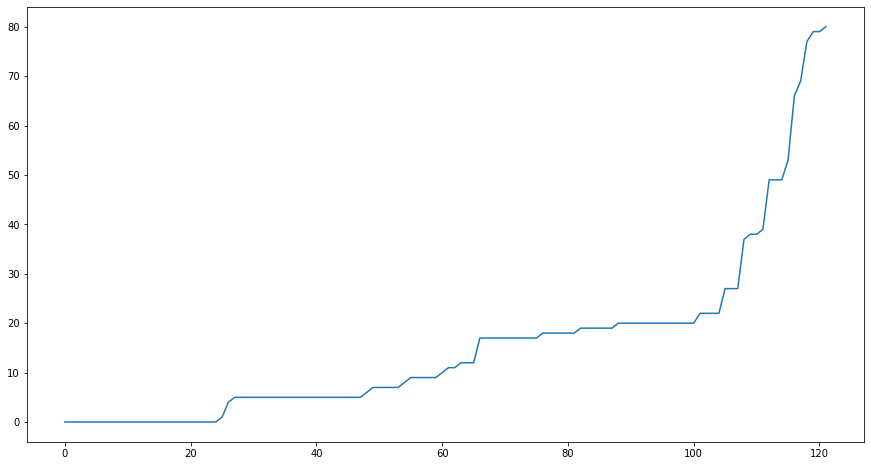

In [154]:
plt.figure(figsize=(15, 8))
plt.plot(np.array(cml_new_case)[0,:])

Text(0.5, 1.0, 'true (red) vs prediction (blue) (all)')

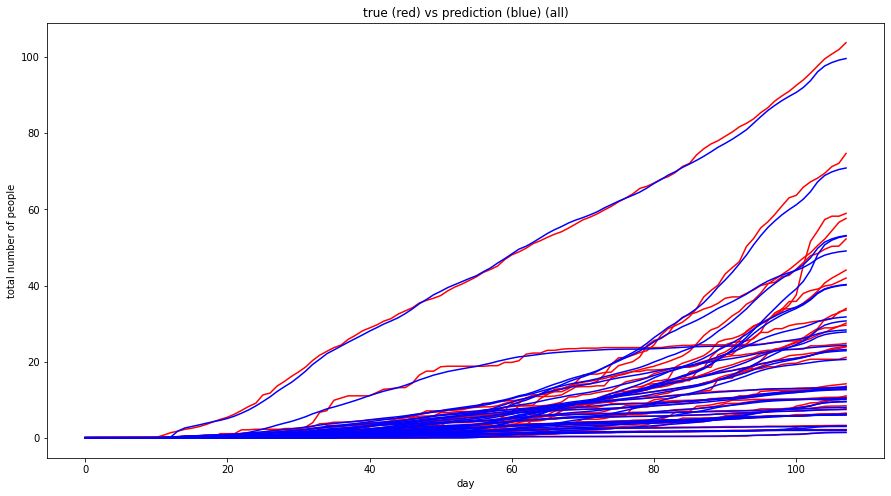

In [113]:
plt.figure(figsize=(15, 8))
plt.plot(trainY, color='red', label='true')
plt.plot(ythat, color='blue', label='prediction')
plt.xlabel("day")
plt.ylabel("total number of people")
plt.title("true (red) vs prediction (blue) (all)")


In [ ]:
trainX.shape

(103, 34, 10)

In [ ]:
trainX[102,5,9]

0.8526441424899008

In [ ]:
train_scaled.shape

(34, 122)

In [ ]:
train_scaled[5,111]

0.8526441424899008

## Rescaling

In [ ]:
# Rescale values

# actual train and test values
train_rescref = np.array(trainY * total_population/500000)
test_rescref = np.array(testY * total_population/500000)

# model predicted values
train_rescpred = np.array((ythat) * total_population/500000)
test_rescpred = np.array((yhat) * total_population/500000)

In [ ]:
## Rescale values
max_case = train_data.max()
min_case = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_case)
#test_rescref = np.array(testY * max_speed)

In [ ]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_case)
#test_rescpred = np.array((yhat) * max_speed)

## Plot of actual and predicted cases on a sample province

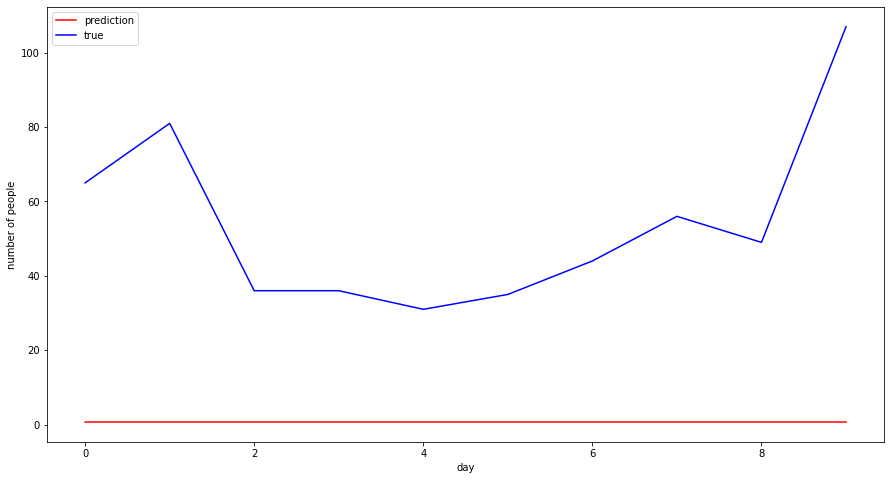

In [ ]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 1]
a_true = test_rescref[:, 1]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("day")
plt.ylabel("number of people")
plt.legend(loc="best", fontsize=10)
plt.show()

# Forecasting using spatio-temporal data with combined Graph Convolution + LSTM model

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

The dynamics of many real-world phenomena are spatio-temporal in nature. Traffic forecasting is a quintessential example of spatio-temporal problems for which we present here a deep learning framework that models speed prediction using spatio-temporal data. The task is challenging due to two main inter-linked factors: (1) the complex spatial dependency on road networks, and (2) non-linear temporal dynamics with changing road conditions.

To address these challenges, here we  explore a neural network architecture that learns from both the spatial road network data and time-series of historical speed changes to forecast speeds on road segments at a future time. In the following we demo how to forecast speeds on road segments through a `graph convolution` and `LSTM` hybrid model.  The spatial dependency of the road networks are learnt through multiple graph convolution layers  stacked over multiple LSTM,  sequence to sequence model, layers that leverage the historical speeds on top of the network structure to predicts speeds in the future for each entity. 

The architecture of the GCN-LSTM model is inspired by the paper: [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://ieeexplore.ieee.org/document/8809901).

The authors have made available the implementation of their model in their GitHub [repository](https://github.com/lehaifeng/T-GCN).
There has been a few differences in the architecture proposed in the paper and the implementation of the graph convolution component, these issues have been documented [here](https://github.com/lehaifeng/T-GCN/issues/18) and [here](https://github.com/lehaifeng/T-GCN/issues/14). The `GCN_LSTM` model in `StellarGraph`  emulates the model as explained in the paper while giving additional flexibility of adding any number of `graph convolution` and `LSTM` layers. 

Concretely, the architecture of `GCN_LSTM` is as follows:

1. User defined number of  graph convolutional layers (Reference: [Kipf & Welling (ICLR 2017)](http://arxiv.org/abs/1609.02907)).
2. User defined number of  LSTM layers. The [TGCN](https://ieeexplore.ieee.org/document/8809901) uses GRU instead of LSTM. In practice there are not any remarkable differences between the two types of layers. We use LSTM as they are more frequently used.
3. A Dropout and a Dense layer as they experimentally showed improvement in performance and managing over-fitting.

## References: 

* [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://ieeexplore.ieee.org/document/8809901)
* [https://github.com/lehaifeng/T-GCN](https://github.com/lehaifeng/T-GCN)
* [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907)

**Note: this method is applicable for uni-variate timeseries forecasting.**

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.0

     |████████████████████████████████| 440kB 3.4MB/s 
     |████████████████████████████████| 235kB 9.1MB/s 
     |████████████████████████████████| 51kB 3.3MB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

## Data

We apply the GCN-LSTM model to the **Los-loop** data. This traffic dataset
contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish
et al., 2014).  There are several processed versions of this dataset used by the research community working in Traffic forecasting space. 

This demo is based on the preprocessed version of the dataset used by the TGCN paper. It can be directly accessed from there [github repo](https://github.com/lehaifeng/T-GCN/tree/master/data). 

This dataset  contains traffic speeds from Mar.1 to Mar.7, 2012 of 207 sensors, recorded every 5 minutes. 

In order to use the model, we need:

* A N by N adjacency matrix, which describes the distance relationship between the N sensors,
* A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.

A couple of other references for the same data albeit different time length are as follows: 

* [DIFFUSION CONVOLUTIONAL RECURRENT NEURAL NETWORK: DATA-DRIVEN TRAFFIC FORECASTING](https://github.com/liyaguang/DCRNN/tree/master/data): This dataset consists of 207 sensors and collect 4 months of data ranging from Mar 1st 2012 to Jun 30th 2012 for the experiment. It has some missing values.
* [ST-MetaNet: Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning](https://github.com/panzheyi/ST-MetaNet/tree/master/traffic-prediction). This work uses the DCRNN preprocessed data.

## Loading and preprocessing the data

In [ ]:
import stellargraph as sg

This demo is based on the preprocessed version of the dataset used by the TGCN paper.

In [ ]:
dataset = sg.datasets.METR_LA()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: METR_LA is experimental: tests and documentation missing (see: https://github.com/stellargraph/stellargraph/issues/1303). It may be difficult to use and may have major changes at any time.
  """Entry point for launching an IPython kernel.


(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [ ]:
speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


In [ ]:
speed_data

# row = node
# coloumn = time-series

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.000000,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,65.222222,62.250000,61.125,58.555556,63.625,66.777778,55.875000,64.333333,63.888889,63.125,62.125,61.500,63.222222,65.000,53.555556,62.125,61.555556,59.875,68.000000,65.375,64.000000,63.222222,58.333333,56.714286,61.777778,66.500,59.750,63.250,60.000000,61.125,...,66.875,67.125,67.444444,66.875000,66.666667,68.625000,67.750000,66.777778,65.111111,68.125000,67.444444,69.125,68.111111,67.666667,67.875,67.875,67.333333,65.375,67.444444,69.000,68.666667,66.875,67.222222,64.125,64.875,67.750,64.875,63.666667,66.000000,65.222222,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.750000,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,63.666667,67.750000,67.000,62.666667,67.000,65.555556,65.500000,66.000000,61.555556,63.875,61.250,62.000,64.111111,63.000,65.777778,67.750,65.222222,64.125,65.888889,63.875,65.250000,62.666667,63.444444,65.285714,67.111111,64.875,69.000,63.375,65.888889,68.000,...,66.250,67.375,67.000000,66.000000,63.777778,65.375000,63.750000,65.777778,58.666667,65.000000,64.777778,57.250,64.777778,66.555556,66.875,67.500,65.777778,66.500,65.555556,66.125,67.444444,66.500,66.888889,67.125,66.500,66.375,65.625,66.111111,67.714286,68.666667,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.000000,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,65.111111,66.875000,58.500,65.777778,55.000,68.111111,60.750000,68.222222,68.111111,65.375,60.750,62.125,64.333333,69.000,64.333333,63.125,66.111111,67.250,64.000000,64.500,60.750000,59.666667,66.000000,62.428571,65.222222,66.375,67.875,63.625,64.666667,60.125,...,67.750,64.375,68.666667,68.250000,68.555556,69.250000,67.875000,67.444444,60.666667,66.500000,67.111111,68.000,67.000000,67.555556,68.125,66.625,67.777778,67.500,68.000000,69.250,67.555556,66.500,67.111111,67.875,67.875,67.750,66.625,67.555556,67.000000,67.000000,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.000000,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,61.111111,60.000000,62.250,59.777778,59.125,59.888889,57.250000,64.777778,57.666667,60.250,61.375,59.375,59.888889,58.875,60.444444,59.875,58.777778,63.375,56.333333,58.125,50.875000,59.666667,58.333333,58.857143,59.000000,54.375,55.500,57.625,56.777778,52.000,...,58.625,55.000,55.555556,58.250000,56.000000,58.750000,58.625000,56.666667,55.000000,57.500000,56.888889,59.875,60.111111,52.333333,59.625,61.500,56.444444,56.500,56.333333,60.250,60.333333,54.625,59.222222,60.625,61.250,62.000,62.500,61.777778,59.428571,63.666667,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.500000,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,66.555556,64.750000,66.375,66.888889,67.625,61.333333,67.875000,68.333333,65.000000,62.500,59.125,62.625,67.000000,67.875,66.666667,65.125,64.888889,68.250,67.000000,66.500,63.375000,65.444444,63.222222,65.428571,62.777778,56.250,66.875,61.625,65.444444,61.375,...,64.750,64.375,63.444444,66.125000,62.888889,65.125000,61.875000,65.666667,59.111111,63.750000,64.111111,63.500,63.666667,57.555556,65.750,62.750,65.333333,63.125,64.555556,66.250,65.444444,67.125,59.333333,59.750,66.500,66.500,66.875,66.555556,67.142857,66.222222,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
sensor_dist_adj

matrix([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.71743792, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.71743792, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ]])

**Let's look at a sample of speed data.**

In [ ]:
speed_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.00,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,65.222222,62.250,61.125,58.555556,63.625,66.777778,55.875,64.333333,63.888889,63.125,62.125,61.500,63.222222,65.000,53.555556,62.125,61.555556,59.875,68.000000,65.375,64.000,63.222222,58.333333,56.714286,61.777778,66.500,59.750,63.250,60.000000,61.125,...,66.875,67.125,67.444444,66.875,66.666667,68.625,67.750,66.777778,65.111111,68.125,67.444444,69.125,68.111111,67.666667,67.875,67.875,67.333333,65.375,67.444444,69.000,68.666667,66.875,67.222222,64.125,64.875,67.750,64.875,63.666667,66.000000,65.222222,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.75,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,63.666667,67.750,67.000,62.666667,67.000,65.555556,65.500,66.000000,61.555556,63.875,61.250,62.000,64.111111,63.000,65.777778,67.750,65.222222,64.125,65.888889,63.875,65.250,62.666667,63.444444,65.285714,67.111111,64.875,69.000,63.375,65.888889,68.000,...,66.250,67.375,67.000000,66.000,63.777778,65.375,63.750,65.777778,58.666667,65.000,64.777778,57.250,64.777778,66.555556,66.875,67.500,65.777778,66.500,65.555556,66.125,67.444444,66.500,66.888889,67.125,66.500,66.375,65.625,66.111111,67.714286,68.666667,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.00,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,65.111111,66.875,58.500,65.777778,55.000,68.111111,60.750,68.222222,68.111111,65.375,60.750,62.125,64.333333,69.000,64.333333,63.125,66.111111,67.250,64.000000,64.500,60.750,59.666667,66.000000,62.428571,65.222222,66.375,67.875,63.625,64.666667,60.125,...,67.750,64.375,68.666667,68.250,68.555556,69.250,67.875,67.444444,60.666667,66.500,67.111111,68.000,67.000000,67.555556,68.125,66.625,67.777778,67.500,68.000000,69.250,67.555556,66.500,67.111111,67.875,67.875,67.750,66.625,67.555556,67.000000,67.000000,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.00,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,61.111111,60.000,62.250,59.777778,59.125,59.888889,57.250,64.777778,57.666667,60.250,61.375,59.375,59.888889,58.875,60.444444,59.875,58.777778,63.375,56.333333,58.125,50.875,59.666667,58.333333,58.857143,59.000000,54.375,55.500,57.625,56.777778,52.000,...,58.625,55.000,55.555556,58.250,56.000000,58.750,58.625,56.666667,55.000000,57.500,56.888889,59.875,60.111111,52.333333,59.625,61.500,56.444444,56.500,56.333333,60.250,60.333333,54.625,59.222222,60.625,61.250,62.000,62.500,61.777778,59.428571,63.666667,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.50,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,66.555556,64.750,66.375,66.888889,67.625,61.333333,67.875,68.333333,65.000000,62.500,59.125,62.625,67.000000,67.875,66.666667,65.125,64.888889,68.250,67.000000,66.500,63.375,65.444444,63.222222,65.428571,62.777778,56.250,66.875,61.625,65.444444,61.375,...,64.750,64.375,63.444444,66.125,62.888889,65.125,61.875,65.666667,59.111111,63.750,64.111111,63.500,63.666667,57.555556,65.750,62.750,65.333333,63.125,64.555556,66.250,65.444444,67.125,59.333333,59.750,66.500,66.500,66.875,66.555556,67.142857,66.222222,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250


As you can see above, there are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes.  This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207  for 7 days (12X24X7).

### Forecasting with spatio-temporal data as a supervised learning problem 

Time series forecasting problem can be cast as a supervised learning problem. We can do this by using previous timesteps as input features and use the next timestep as the output to predict. Then, the spatio-temporal forecasting question can be modeled as predicting the feature value in the future, given the historical values of the feature for that entity  as well as the feature values of the entities "connected" to the entity.  For example, the speed prediction problem, the historical speeds of the sensors are the timeseries and the distance between the sensors is the indicator for connectivity or closeness of sensors.

### Train/test split

Just like for modeling any standard supervised learning problem, we first split the data into mutually exclusive train and test sets. However, unlike, a standard supervised learning problem,  in timeseries analysis, the data is in some chronological time respecting order and the train/test happens along the timeline. Lets say, we use the first `T_t` observations for training and the remaining `T - T_t` of the  total `T` observations for testing.  

In the following we use first 80% observations for training and the rest for testing.

In [ ]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [ ]:
train_rate = 0.8

In [ ]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (207, 1612)
Test data:  (207, 404)


### Scaling
It is generally a good practice to  rescale the data from the original range so that all values are within the range of 0 and 1. Normalization can be useful and even necessary when your time series data has input values with differing scales.  In the following we normalize the speed timeseries by the maximum and minimum values of speeds in the train data. 

Note: `MinMaxScaler` in `scikit learn` library is typically used for transforming data. However, in timeseries data since the features are distinct timesteps, so using the historical range of values in a particular timestep as the range of values in later timesteps, may not be correct.  Hence, we use the maximum and the minimum of the entire range of values in the timeseries to scale and transform the train and test sets respectively.

In [ ]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [ ]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data preparation for LSTM

We first need to prepare the data to be fed into an LSTM. 
The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

To make it concrete in terms of the speed prediction problem, we choose to use 50 minutes of historical speed observations to predict the speed in future, lets say, 1 hour ahead. Hence, we would first  reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:  

* Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict. 
* Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict. 
* Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.
* The above steps are done for each sensor. 

The function below returns the above transformed timeseries data for the model to train on. The parameter `seq_len` is the size of the past window of information. The `pre_len` is how far in the future does the model need to learn to predict. 

For this demo: 

* Each training observation are 10 historical speeds (`seq_len`).
* Each training prediction is the speed 60 minutes later (`pre_len`).

In [ ]:
seq_len = 10
pre_len = 12

In [ ]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [ ]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 207, 10)
(1591, 207)
(383, 207, 10)
(383, 207)


## StellarGraph Graph Convolution and LSTM model

In [ ]:
from stellargraph.layer import GCN_LSTM

In [ ]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

In [ ]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [ ]:
model = Model(inputs=x_input, outputs=x_output)

In [ ]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [ ]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 207, 10)]         0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 207, 10, 1)]      0         
_________________________________________________________________
reshape (Reshape)            (None, 207, 10)           0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 16)           43216     
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 10)           43216     
_________________________________________________________________
reshape_1 (Reshape)          (None, 207, None, 1)      0         
_________________________________________________________________
permute (Permute)            (None, None, 207, 1)      0     

In [ ]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.05109991133213043 
Test loss: 0.0


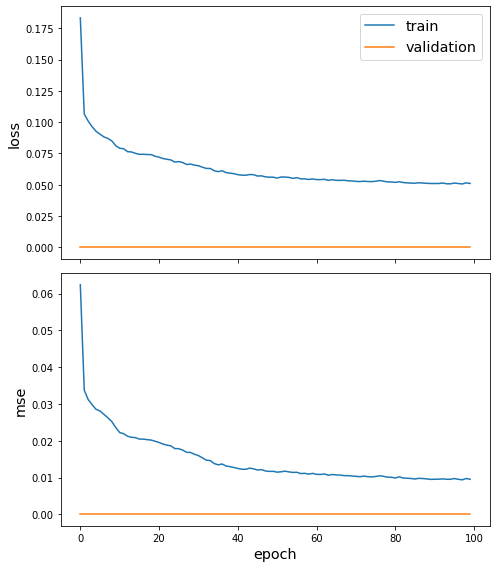

In [ ]:
sg.utils.plot_history(history)

In [ ]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

## Rescale values

Rescale the predicted values to the original value range of the timeseries.

In [ ]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [ ]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Measuring the performance of the model

To understand how well the model is performing, we compare it against a naive benchmark.

1. Naive prediction: using the most recently **observed** value as the predicted value. Note, that albeit being **naive** this is a very strong baseline to beat. Especially, when speeds are recorded at a 5 minutes granularity,  one does not expect many drastic changes within such a short period of time. Hence, for short-term predictions naive is a reasonable good guess.

### Naive prediction benchmark (using latest observed value)

In [ ]:
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [ ]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 3.8822542511393068
Total (ave) MAE for naive prediction: 5.619645381284217
Total (ave) MASE for per-segment NN/naive MAE: 0.6846969434482696
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


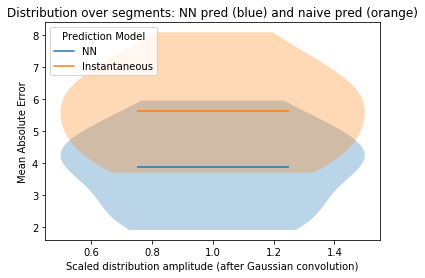

In [ ]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Plot of actual and predicted speeds on a sample sensor

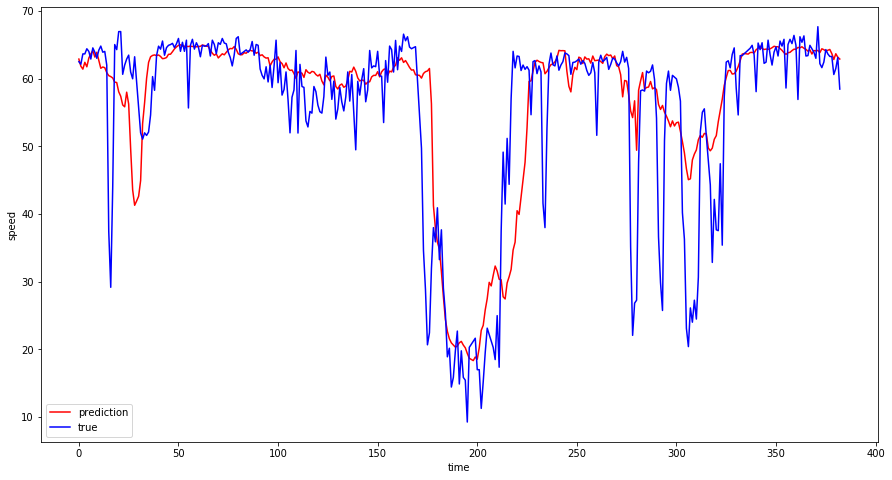

In [ ]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>